# Import Modules

In [1]:
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics import F1Score
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters Config

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=75,
        input_size_left_context=64,
        input_size_oov_context=20,
        input_size_right_context=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        output_size=3611,
        shuffle=True,
        lr=0.001,
        batch_first=True,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=20,
        patience=20,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.input_size_left_context = input_size_left_context
        self.input_size_oov_context = input_size_oov_context
        self.input_size_right_context = input_size_right_context
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device
        
hyperparams = Hyperparams()

# Prepare Feature Dataset

In [3]:
def convert_doc_to_idxs(docs, dict_vocabs):
    doc_to_idx = []
    
    for doc in docs:
        doc_to_idx.append([dict_vocabs[token] for token in doc])
        
    return np.array(doc_to_idx)

# Left context
left_context = open(f"../../datasets/features/{hyperparams.context_size}_context/left_context_with_pad.pkl", "rb")
left_context = pickle.load(left_context)
left_context_to_idx = open(f"../../datasets/features/{hyperparams.context_size}_context/token2idx_left_context.pkl", "rb")
left_context_to_idx = pickle.load(left_context_to_idx)
doc_left_context_to_idx = convert_doc_to_idxs(left_context, left_context_to_idx)

# OOV context
oov_context = open(f"../../datasets/features/{hyperparams.context_size}_context/oov_context_with_pad.pkl", "rb")
oov_context = pickle.load(oov_context)
oov_context_to_idx = open(f"../../datasets/features/{hyperparams.context_size}_context/token2idx_oov_context.pkl", "rb")
oov_context_to_idx = pickle.load(oov_context_to_idx)
doc_oov_context_to_idx = convert_doc_to_idxs(oov_context, oov_context_to_idx)

# Right context
right_context = open(f"../../datasets/features/{hyperparams.context_size}_context/right_context_with_pad.pkl", "rb")
right_context = pickle.load(right_context)
right_context_to_idx = open(f"../../datasets/features/{hyperparams.context_size}_context/token2idx_right_context.pkl", "rb")
right_context_to_idx = pickle.load(right_context_to_idx)
doc_right_context_to_idx = convert_doc_to_idxs(right_context, right_context_to_idx)

# Actual labels
labels_context = open(f"../../datasets/features/{hyperparams.context_size}_context/lables.pkl", "rb")
labels_context = pickle.load(labels_context)
labels_to_idx = open(f"../../datasets/features/{hyperparams.context_size}_context/lable_vocabs.pkl", "rb")
labels_to_idx = pickle.load(labels_to_idx)
doc_labels_to_idx = convert_doc_to_idxs(labels_context, labels_to_idx).flatten()

print(f"Left context shape: {doc_left_context_to_idx.shape}")
print(f"OOV context shape: {doc_oov_context_to_idx.shape}")
print(f"Right context shape: {doc_right_context_to_idx.shape}")
print(f"Actual lable shape: {doc_labels_to_idx.shape}")

Left context shape: (16562, 70)
OOV context shape: (16562, 28)
Right context shape: (16562, 73)
Actual lable shape: (16562,)


In [4]:
# Convert to Tensor
left_contexts = torch.LongTensor(doc_left_context_to_idx)
oov_contexts = torch.LongTensor(doc_oov_context_to_idx)
right_contexts = torch.LongTensor(doc_right_context_to_idx)
actual_labels = torch.LongTensor(doc_labels_to_idx)
dataset = TensorDataset(left_contexts, oov_contexts, right_contexts, actual_labels)

# Char and Word Embedding

In [5]:
# Word Embedding
word_embeddings = Embedding.load("../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
word_embeddings.apply_expansion(DigitExpander)
word_embeddings.apply_expansion(CaseExpander)

left_vocabs = open(f"../../datasets/features/{hyperparams.context_size}_context/left_context_vocabs.pkl", "rb")
left_vocabs = pickle.load(left_vocabs)

right_vocabs = open(f"../../datasets/features/{hyperparams.context_size}_context/right_context_vocabs.pkl", "rb")
right_vocabs = pickle.load(right_vocabs)

left_word_embedding_dict = {left_context_to_idx[vocab] : word_embeddings[vocab] for vocab in left_vocabs}
right_word_embedding_dict = {right_context_to_idx[vocab] : word_embeddings[vocab] for vocab in right_vocabs}

# Char Embedding
char_embedding_dict = open("../../word_embeddings/chars_embedding/char_embeddings.pkl", "rb")
char_embedding_dict = pickle.load(char_embedding_dict)

# Context embedding
left_context_embedding = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(left_word_embedding_dict.values()))), padding_idx=left_vocabs.index("<PAD>"), freeze=True)
oov_context_embedding = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(char_embedding_dict.values()))), padding_idx=list(char_embedding_dict.keys()).index("PAD"), freeze=True)
right_context_embedding = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(right_word_embedding_dict.values()))), padding_idx=right_vocabs.index("<PAD>"), freeze=True)

# Dataloader

In [6]:
dataloader = DataLoader(dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

# Model

In [7]:
class Comick(nn.Module):
    def __init__(
        self,
        input_size_left_context=hyperparams.input_size_left_context,
        input_size_oov_context=hyperparams.input_size_oov_context,
        input_size_right_context=hyperparams.input_size_right_context,
        hidden_size=hyperparams.hidden_size,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(Comick, self).__init__()
        
        self.input_size_left_context = input_size_left_context
        self.input_size_oov_context = input_size_oov_context
        self.input_size_right_context = input_size_right_context
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        
        self.bilstm_left_context_feature = nn.LSTM(
            input_size = self.input_size_left_context,
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.bilstm_oov_context_feature = nn.LSTM(
            input_size = self.input_size_oov_context,
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.bilstm_right_context_feature = nn.LSTM(
            input_size = self.input_size_right_context,
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.fc = nn.Sequential(
            nn.Linear(2 * self.hidden_size, 64),
            nn.Tanh()
        )
        
        self.oov_embedding = nn.Linear(in_features=3 * 64, out_features=64)
        
        self.embedding = np.empty((output_size, 64), dtype=np.float32)
        
        self.prob = nn.Sequential(
            nn.Linear(64, self.output_size),
            nn.LogSoftmax(dim=1)
        )
                
        if init_wb_with_kaiming_normal:
            self.init_wb()
            
    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))

    def forward(
        self,
        input_left_context,
        input_oov_context,
        input_right_context,
        idxs_target,
        hidden_left_context=None,
        hidden_oov_context=None,
        hidden_right_context=None,
    ):
        # BiLSTM left, oov, and right context
        output_left_context, (hidden_left_context, memory_left_context) = self.bilstm_left_context_feature(input_left_context, hidden_left_context)
        output_oov_context, (hidden_oov_context, memory_oov_context) = self.bilstm_oov_context_feature(input_oov_context, hidden_oov_context)
        output_right_context, (hidden_right_context, memory_right_context) = self.bilstm_right_context_feature(input_right_context, hidden_right_context)
                
        # Concate hidden (forward and backward hidden BiLSTM)
        hidden_left_bidirectional = torch.cat((hidden_left_context[0], hidden_left_context[-1]), dim=1)
        hidden_oov_bidirectional = torch.cat((hidden_oov_context[0], hidden_oov_context[-1]), dim=1)
        hidden_right_bidirectional = torch.cat((hidden_right_context[0], hidden_right_context[-1]), dim=1)
        
        # Fully connected
        output_left_fc = self.fc(hidden_left_bidirectional)
        output_oov_fc = self.fc(hidden_oov_bidirectional)
        output_right_fc = self.fc(hidden_right_bidirectional)
        
        # Concate output left, oov, and right context feature
        output = torch.cat((output_left_fc, output_oov_fc, output_right_fc), dim=1)
        
        # OOV embedding
        output = self.oov_embedding(output)
                
        # save OOV embedding
        self.embedding[idxs_target.tolist()] = output.cpu().detach().numpy()
        
        # Projection OOV embedding
        prob = self.prob(output)
        
        return prob

# Model, Optimizer, Criterion, Metric, and Learning Rate Scheduler

In [8]:
model = Comick().to(hyperparams.device)
model.prob[0].requires_grad_ = False # disable gradient for projection layer
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.NLLLoss(ignore_index=list(char_embedding_dict.keys()).index("PAD")).to(hyperparams.device)
metric = F1Score(ignore_index=list(char_embedding_dict.keys()).index("PAD")).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5)
model

Comick(
  (bilstm_left_context_feature): LSTM(64, 128, batch_first=True, bidirectional=True)
  (bilstm_oov_context_feature): LSTM(20, 128, batch_first=True, bidirectional=True)
  (bilstm_right_context_feature): LSTM(64, 128, batch_first=True, bidirectional=True)
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): Tanh()
  )
  (oov_embedding): Linear(in_features=192, out_features=64, bias=True)
  (prob): Sequential(
    (0): Linear(in_features=64, out_features=3611, bias=True)
    (1): LogSoftmax(dim=1)
  )
)

In [9]:
print(f"{sum([param.numel() for param in model.parameters() if param.requires_grad_]):,}")

814,427


In [10]:
model.embedding

array([[-5.7093925e-18,  4.5875709e-41, -5.7093925e-18, ...,
         0.0000000e+00,  1.7934352e-27,  4.5875709e-41],
       [ 2.1663284e-28,  4.5875709e-41,  1.0404081e-40, ...,
         4.5875709e-41,  1.0405482e-40,  0.0000000e+00],
       [ 1.7935030e-27,  4.5875709e-41,  2.1665133e-28, ...,
         4.5875709e-41,  2.1666673e-28,  4.5875709e-41],
       ...,
       [ 1.6045404e-28,  4.5875709e-41,  2.1464220e-28, ...,
         4.5875709e-41,  2.1465760e-28,  4.5875709e-41],
       [ 1.1345613e-40,  0.0000000e+00,  1.6045828e-28, ...,
         0.0000000e+00,  1.6046213e-28,  4.5875709e-41],
       [ 2.1467455e-28,  4.5875709e-41,  1.1347154e-40, ...,
         4.5875709e-41,  1.1348556e-40,  0.0000000e+00]], dtype=float32)

# Training Step

In [11]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None, path_name=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (input_left_context, input_oov_context, input_right_context, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        prob = model(
            left_context_embedding(input_left_context).to(hyperparams.device),
            oov_context_embedding(input_oov_context).to(hyperparams.device),
            right_context_embedding(input_right_context).to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
                
        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
        metric_score = metric.compute()
        
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if batch % 50 == 0 or batch == len(dataloader):
            batch_name = "Batch-" + str(batch)
            print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
            with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
                f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")

        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

# Looping Step

EPOCH-1


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=6.1964 | F1Score=0.2569
Batch-100: NLLLoss=4.7256 | F1Score=0.2972
Batch-150: NLLLoss=5.7057 | F1Score=0.3106
Batch-200: NLLLoss=3.9199 | F1Score=0.3322
Batch-250: NLLLoss=3.1171 | F1Score=0.3548
Batch-300: NLLLoss=3.5555 | F1Score=0.3745
Batch-350: NLLLoss=3.7680 | F1Score=0.3912
Batch-400: NLLLoss=3.4508 | F1Score=0.4046
Batch-450: NLLLoss=4.9516 | F1Score=0.4172
Batch-500: NLLLoss=2.6373 | F1Score=0.4302
Batch-518: NLLLoss=1.4986 | F1Score=0.4357

Mean NLLLoss: 4.5231 | Mean F1Score: 0.3466

EPOCH-2


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=4.3062 | F1Score=0.5969
Batch-100: NLLLoss=3.4311 | F1Score=0.5963
Batch-150: NLLLoss=2.3704 | F1Score=0.6032
Batch-200: NLLLoss=2.1314 | F1Score=0.6130
Batch-250: NLLLoss=1.9218 | F1Score=0.6219
Batch-300: NLLLoss=2.7350 | F1Score=0.6264
Batch-350: NLLLoss=4.0043 | F1Score=0.6298
Batch-400: NLLLoss=2.4300 | F1Score=0.6349
Batch-450: NLLLoss=2.6664 | F1Score=0.6380
Batch-500: NLLLoss=3.3792 | F1Score=0.6423
Batch-518: NLLLoss=1.8223 | F1Score=0.6440

Yeah 🎉😄! Model improved.
Mean NLLLoss: 2.6799 | Mean F1Score: 0.6194

EPOCH-3


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=2.2479 | F1Score=0.7331
Batch-100: NLLLoss=1.8120 | F1Score=0.7341
Batch-150: NLLLoss=2.3277 | F1Score=0.7299
Batch-200: NLLLoss=2.1023 | F1Score=0.7333
Batch-250: NLLLoss=1.1819 | F1Score=0.7338
Batch-300: NLLLoss=1.1156 | F1Score=0.7390
Batch-350: NLLLoss=1.6171 | F1Score=0.7426
Batch-400: NLLLoss=1.7566 | F1Score=0.7445
Batch-450: NLLLoss=2.0020 | F1Score=0.7478
Batch-500: NLLLoss=1.6255 | F1Score=0.7491
Batch-518: NLLLoss=1.8228 | F1Score=0.7501

Yeah 🎉😄! Model improved.
Mean NLLLoss: 1.7674 | Mean F1Score: 0.7388

EPOCH-4


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.8565 | F1Score=0.8306
Batch-100: NLLLoss=0.6488 | F1Score=0.8138
Batch-150: NLLLoss=1.3516 | F1Score=0.8163
Batch-200: NLLLoss=0.4816 | F1Score=0.8152
Batch-250: NLLLoss=0.9638 | F1Score=0.8167
Batch-300: NLLLoss=0.8787 | F1Score=0.8177
Batch-350: NLLLoss=1.0396 | F1Score=0.8207
Batch-400: NLLLoss=1.1555 | F1Score=0.8211
Batch-450: NLLLoss=0.8277 | F1Score=0.8197
Batch-500: NLLLoss=1.3204 | F1Score=0.8206
Batch-518: NLLLoss=1.0045 | F1Score=0.8206

Yeah 🎉😄! Model improved.
Mean NLLLoss: 1.1491 | Mean F1Score: 0.8188

EPOCH-5


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.4795 | F1Score=0.9019
Batch-100: NLLLoss=0.4740 | F1Score=0.8930
Batch-150: NLLLoss=0.8050 | F1Score=0.8836
Batch-200: NLLLoss=0.8604 | F1Score=0.8810
Batch-250: NLLLoss=0.5603 | F1Score=0.8804
Batch-300: NLLLoss=1.0023 | F1Score=0.8780
Batch-350: NLLLoss=0.7605 | F1Score=0.8759
Batch-400: NLLLoss=0.6782 | F1Score=0.8764
Batch-450: NLLLoss=0.5919 | F1Score=0.8775
Batch-500: NLLLoss=0.9391 | F1Score=0.8747
Batch-518: NLLLoss=0.7334 | F1Score=0.8751

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.6854 | Mean F1Score: 0.8832

EPOCH-6


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.3874 | F1Score=0.9559
Batch-100: NLLLoss=0.1527 | F1Score=0.9551
Batch-150: NLLLoss=0.3510 | F1Score=0.9530
Batch-200: NLLLoss=0.2589 | F1Score=0.9504
Batch-250: NLLLoss=0.5146 | F1Score=0.9464
Batch-300: NLLLoss=0.4397 | F1Score=0.9463
Batch-350: NLLLoss=0.4288 | F1Score=0.9460
Batch-400: NLLLoss=0.8414 | F1Score=0.9441
Batch-450: NLLLoss=0.5383 | F1Score=0.9414
Batch-500: NLLLoss=0.2849 | F1Score=0.9396
Batch-518: NLLLoss=0.4429 | F1Score=0.9394

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.3320 | Mean F1Score: 0.9488

EPOCH-7


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.1837 | F1Score=0.9906
Batch-100: NLLLoss=0.0673 | F1Score=0.9925
Batch-150: NLLLoss=0.1574 | F1Score=0.9933
Batch-200: NLLLoss=0.1165 | F1Score=0.9931
Batch-250: NLLLoss=0.0806 | F1Score=0.9912
Batch-300: NLLLoss=0.2765 | F1Score=0.9887
Batch-350: NLLLoss=0.0485 | F1Score=0.9883
Batch-400: NLLLoss=0.0999 | F1Score=0.9882
Batch-450: NLLLoss=0.1927 | F1Score=0.9878
Batch-500: NLLLoss=0.0809 | F1Score=0.9873
Batch-518: NLLLoss=0.0965 | F1Score=0.9873

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.1108 | Mean F1Score: 0.9905

EPOCH-8


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0470 | F1Score=0.9981
Batch-100: NLLLoss=0.0477 | F1Score=0.9987
Batch-150: NLLLoss=0.0118 | F1Score=0.9987
Batch-200: NLLLoss=0.0266 | F1Score=0.9986
Batch-250: NLLLoss=0.0312 | F1Score=0.9989
Batch-300: NLLLoss=0.0530 | F1Score=0.9986
Batch-350: NLLLoss=0.0115 | F1Score=0.9988
Batch-400: NLLLoss=0.0173 | F1Score=0.9988
Batch-450: NLLLoss=0.0118 | F1Score=0.9985
Batch-500: NLLLoss=0.0142 | F1Score=0.9984
Batch-518: NLLLoss=0.0213 | F1Score=0.9983

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0307 | Mean F1Score: 0.9987

EPOCH-9


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0156 | F1Score=0.9987
Batch-100: NLLLoss=0.0036 | F1Score=0.9984
Batch-150: NLLLoss=0.0059 | F1Score=0.9987
Batch-200: NLLLoss=0.0115 | F1Score=0.9989
Batch-250: NLLLoss=0.0205 | F1Score=0.9990
Batch-300: NLLLoss=0.0060 | F1Score=0.9990
Batch-350: NLLLoss=0.0101 | F1Score=0.9990
Batch-400: NLLLoss=0.0044 | F1Score=0.9991
Batch-450: NLLLoss=0.0080 | F1Score=0.9992
Batch-500: NLLLoss=0.0051 | F1Score=0.9991
Batch-518: NLLLoss=0.0131 | F1Score=0.9992

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0125 | Mean F1Score: 0.9989

EPOCH-10


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0047 | F1Score=0.9997
Batch-100: NLLLoss=0.0058 | F1Score=0.9995
Batch-150: NLLLoss=0.0050 | F1Score=0.9996
Batch-200: NLLLoss=0.0070 | F1Score=0.9992
Batch-250: NLLLoss=0.0068 | F1Score=0.9992
Batch-300: NLLLoss=0.0057 | F1Score=0.9994
Batch-350: NLLLoss=0.0091 | F1Score=0.9994
Batch-400: NLLLoss=0.0038 | F1Score=0.9993
Batch-450: NLLLoss=0.0068 | F1Score=0.9992
Batch-500: NLLLoss=0.0071 | F1Score=0.9992
Batch-518: NLLLoss=0.0027 | F1Score=0.9992

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0092 | Mean F1Score: 0.9994

EPOCH-11


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0039 | F1Score=1.0000
Batch-100: NLLLoss=0.0041 | F1Score=0.9997
Batch-150: NLLLoss=0.0042 | F1Score=0.9994
Batch-200: NLLLoss=0.0037 | F1Score=0.9995
Batch-250: NLLLoss=0.0037 | F1Score=0.9995
Batch-300: NLLLoss=0.0034 | F1Score=0.9995
Batch-350: NLLLoss=0.0029 | F1Score=0.9995
Batch-400: NLLLoss=0.0090 | F1Score=0.9995
Batch-450: NLLLoss=0.0036 | F1Score=0.9995
Batch-500: NLLLoss=0.0044 | F1Score=0.9995
Batch-518: NLLLoss=0.0042 | F1Score=0.9995

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0053 | Mean F1Score: 0.9996

EPOCH-12


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0043 | F1Score=1.0000
Batch-100: NLLLoss=0.0028 | F1Score=0.9997
Batch-150: NLLLoss=0.0047 | F1Score=0.9998
Batch-200: NLLLoss=0.0027 | F1Score=0.9998
Batch-250: NLLLoss=0.0031 | F1Score=0.9997
Batch-300: NLLLoss=0.0034 | F1Score=0.9997
Batch-350: NLLLoss=0.0062 | F1Score=0.9997
Batch-400: NLLLoss=0.0036 | F1Score=0.9998
Batch-450: NLLLoss=0.0022 | F1Score=0.9997
Batch-500: NLLLoss=0.0021 | F1Score=0.9997
Batch-518: NLLLoss=0.0022 | F1Score=0.9997

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0038 | Mean F1Score: 0.9998

EPOCH-13


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0035 | F1Score=1.0000
Batch-100: NLLLoss=0.0022 | F1Score=1.0000
Batch-150: NLLLoss=0.0034 | F1Score=0.9998
Batch-200: NLLLoss=0.0010 | F1Score=0.9998
Batch-250: NLLLoss=0.0082 | F1Score=0.9997
Batch-300: NLLLoss=0.0019 | F1Score=0.9997
Batch-350: NLLLoss=0.0022 | F1Score=0.9997
Batch-400: NLLLoss=0.0014 | F1Score=0.9998
Batch-450: NLLLoss=0.0016 | F1Score=0.9997
Batch-500: NLLLoss=0.0025 | F1Score=0.9997
Batch-518: NLLLoss=0.0056 | F1Score=0.9997

Huft 😥! Model not improved.
Mean NLLLoss: 0.0044 | Mean F1Score: 0.9998
Patience = 1/20❗

EPOCH-14


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0046 | F1Score=0.9994
Batch-100: NLLLoss=0.0023 | F1Score=0.9997
Batch-150: NLLLoss=0.0023 | F1Score=0.9996
Batch-200: NLLLoss=0.0016 | F1Score=0.9997
Batch-250: NLLLoss=0.0015 | F1Score=0.9996
Batch-300: NLLLoss=0.0014 | F1Score=0.9996
Batch-350: NLLLoss=0.0013 | F1Score=0.9997
Batch-400: NLLLoss=0.0014 | F1Score=0.9997
Batch-450: NLLLoss=0.0028 | F1Score=0.9996
Batch-500: NLLLoss=0.0032 | F1Score=0.9996
Batch-518: NLLLoss=0.0179 | F1Score=0.9995

Huft 😥! Model not improved.
Mean NLLLoss: 0.0044 | Mean F1Score: 0.9995
Patience = 2/20❗

EPOCH-15


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.7368 | F1Score=0.9812
Batch-100: NLLLoss=0.2141 | F1Score=0.9248
Batch-150: NLLLoss=0.2077 | F1Score=0.8988
Batch-200: NLLLoss=0.1011 | F1Score=0.8959
Batch-250: NLLLoss=0.2707 | F1Score=0.8997
Batch-300: NLLLoss=0.3018 | F1Score=0.9021
Batch-350: NLLLoss=0.1961 | F1Score=0.9046
Batch-400: NLLLoss=0.2056 | F1Score=0.9090
Batch-450: NLLLoss=0.1702 | F1Score=0.9135
Batch-500: NLLLoss=0.0454 | F1Score=0.9181
Batch-518: NLLLoss=0.1730 | F1Score=0.9188

Huft 😥! Model not improved.
Mean NLLLoss: 0.3261 | Mean F1Score: 0.9181
Patience = 3/20❗

EPOCH-16


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0130 | F1Score=0.9937
Batch-100: NLLLoss=0.0173 | F1Score=0.9942
Batch-150: NLLLoss=0.1021 | F1Score=0.9950
Batch-200: NLLLoss=0.0326 | F1Score=0.9947
Batch-250: NLLLoss=0.0276 | F1Score=0.9949
Batch-300: NLLLoss=0.0079 | F1Score=0.9953
Batch-350: NLLLoss=0.0203 | F1Score=0.9952
Batch-400: NLLLoss=0.0319 | F1Score=0.9955
Batch-450: NLLLoss=0.0051 | F1Score=0.9956
Batch-500: NLLLoss=0.0934 | F1Score=0.9958
Batch-518: NLLLoss=0.0033 | F1Score=0.9958

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0253 | Mean F1Score: 0.9948

EPOCH-17


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0017 | F1Score=0.9994
Batch-100: NLLLoss=0.0018 | F1Score=0.9997
Batch-150: NLLLoss=0.0020 | F1Score=0.9998
Batch-200: NLLLoss=0.0022 | F1Score=0.9998
Batch-250: NLLLoss=0.0025 | F1Score=0.9999
Batch-300: NLLLoss=0.0011 | F1Score=0.9999
Batch-350: NLLLoss=0.0017 | F1Score=0.9998
Batch-400: NLLLoss=0.0016 | F1Score=0.9998
Batch-450: NLLLoss=0.0019 | F1Score=0.9998
Batch-500: NLLLoss=0.0029 | F1Score=0.9998
Batch-518: NLLLoss=0.0004 | F1Score=0.9998

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0030 | Mean F1Score: 0.9998

EPOCH-18


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0010 | F1Score=1.0000
Batch-100: NLLLoss=0.0005 | F1Score=1.0000
Batch-150: NLLLoss=0.0013 | F1Score=0.9999
Batch-200: NLLLoss=0.0011 | F1Score=0.9998
Batch-250: NLLLoss=0.0009 | F1Score=0.9998
Batch-300: NLLLoss=0.0009 | F1Score=0.9998
Batch-350: NLLLoss=0.0016 | F1Score=0.9999
Batch-400: NLLLoss=0.0025 | F1Score=0.9999
Batch-450: NLLLoss=0.0014 | F1Score=0.9998
Batch-500: NLLLoss=0.0022 | F1Score=0.9997
Batch-518: NLLLoss=0.0007 | F1Score=0.9998

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0025 | Mean F1Score: 0.9999

EPOCH-19


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0013 | F1Score=0.9994
Batch-100: NLLLoss=0.0008 | F1Score=0.9994
Batch-150: NLLLoss=0.0009 | F1Score=0.9996
Batch-200: NLLLoss=0.0016 | F1Score=0.9997
Batch-250: NLLLoss=0.0018 | F1Score=0.9998
Batch-300: NLLLoss=0.0007 | F1Score=0.9997
Batch-350: NLLLoss=0.0008 | F1Score=0.9998
Batch-400: NLLLoss=0.0009 | F1Score=0.9997
Batch-450: NLLLoss=0.0013 | F1Score=0.9998
Batch-500: NLLLoss=0.0010 | F1Score=0.9997
Batch-518: NLLLoss=0.0008 | F1Score=0.9998

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0016 | Mean F1Score: 0.9997

EPOCH-20


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0003 | F1Score=1.0000
Batch-100: NLLLoss=0.0009 | F1Score=1.0000
Batch-150: NLLLoss=0.0009 | F1Score=1.0000
Batch-200: NLLLoss=0.0009 | F1Score=1.0000
Batch-250: NLLLoss=0.0004 | F1Score=1.0000
Batch-300: NLLLoss=0.0011 | F1Score=1.0000
Batch-350: NLLLoss=0.0008 | F1Score=1.0000
Batch-400: NLLLoss=0.0009 | F1Score=1.0000
Batch-450: NLLLoss=0.0005 | F1Score=1.0000
Batch-500: NLLLoss=0.0008 | F1Score=0.9999
Batch-518: NLLLoss=0.0006 | F1Score=0.9999

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0008 | Mean F1Score: 1.0000

TRAINING SUMMARY
Best NLLLoss      : 0.0008
Best F1Score      : 1.0000
Training duration : 34.174 minutes.
Training date     : 2022-10-11 18:36:07.451122+08:00


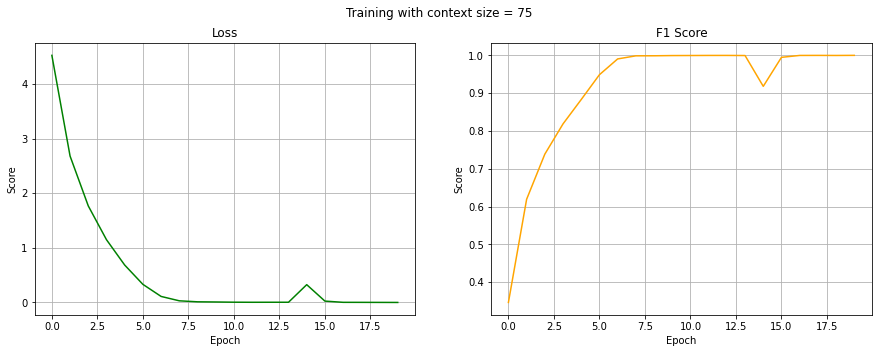

In [12]:
def looping_step(dataloader, model, optimizer, criterion, metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_losses = []
    epoch_metric_scores = []
    patience_counter = 0
    
    now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
    path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
    os.makedirs(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}")
    
    # Hyperparameters
    with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 50}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 50}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
        
        batch_losses, batch_metric_scores = training_step(dataloader, model, optimizer, criterion, metric, path_name=path_name)
        epoch_loss = torch.mean(torch.FloatTensor(batch_losses))

        epoch_loss = torch.mean(torch.FloatTensor(batch_losses))
        epoch_losses.append(epoch_loss.item())

        epoch_metric_score = torch.mean(torch.FloatTensor(batch_metric_scores))
        epoch_metric_scores.append(epoch_metric_score.item())
        
        with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_loss = (epoch_loss)
                    best_metric = (epoch_metric_score)
                    
                    print(f"\nMean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    
                    f.write(f"\nMean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                elif epoch_losses[-1] < epoch_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_loss = (epoch_loss)
                    best_metric = (epoch_metric_score)
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")                    
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_loss = (epoch_loss)
                    best_metric = (epoch_metric_score)
                    
                    print(f"\nMean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    
                    f.write(f"\nMean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                elif epoch_metric_scores[-1] > epoch_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_loss = (epoch_loss)
                    best_metric = (epoch_metric_score)
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 50, end="\n\n")
            f.write(f"{'=' * 50}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        metric.reset()
    
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_losses, "green")
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_metric_scores, "orange")
    ax_metric_score.grid()

    plt.savefig(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    criterion_name = "Best " + str(criterion).split('(')[0]
    metric_name = "Best " + str(metric).split('(')[0]
    
    print(f"{criterion_name.ljust(18)}: {best_loss:.4f}")
    print(f"{metric_name.ljust(18)}: {best_metric:.4f}")
    print(f"{'Training duration'.ljust(18)}: {((finish_time - start_time) / 60):.3f} minutes.")
    print(f"{'Training date'.ljust(18)}: {now}")
    
    with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 50}\n")
        f.write(f"{criterion_name.ljust(18)}: {best_loss:.4f}\n")
        f.write(f"{metric_name.ljust(18)}: {best_metric:.4f}\n")
        f.write(f"{'Training duration'.ljust(18)}: {((finish_time - start_time) / 60):.3f} minutes.\n")
        f.write(f"{'Training date'.ljust(18)}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    filename_model_params = f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/model_params.pth"
    filename_oov_embedding_dict = open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/oov_embedding_dict.pkl", "ab")
    
    pd.DataFrame(
        data={
            "epoch": list(range(1, len(epoch_losses) + 1)),
            "loss": epoch_losses
        }
    ).to_csv(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/epoch_losses.csv", index=False)
    
    pd.DataFrame(
        data={
            "epoch": list(range(1, len(epoch_metric_scores) + 1)),
            "f1_score": epoch_metric_scores
        }
    ).to_csv(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/epoch_metric_scores.csv", index=False)
    
    torch.save(best_state_dict, filename_model_params)
    pickle.dump({token : embedding for token, embedding in zip(list(labels_to_idx.keys()), model.embedding)}, filename_oov_embedding_dict)
    
    return epoch_losses, epoch_metric_scores

epoch_losses, epoch_metric_scores = looping_step(dataloader, model, optimizer, criterion, metric)

# END

In [13]:
model.embedding

array([[ 5.123893  , -4.758261  ,  2.4090116 , ..., -5.3842897 ,
        -1.1657342 , -0.5031694 ],
       [ 2.6494255 , -2.9381366 ,  5.783752  , ..., -2.6590643 ,
         2.869532  , -0.581211  ],
       [ 2.5816772 , -4.116673  ,  3.3116522 , ..., -1.1632373 ,
         5.8818603 , -0.10008387],
       ...,
       [-4.815262  ,  0.8319473 ,  0.73953366, ..., -4.19462   ,
        -0.09331445,  3.5281932 ],
       [-6.008277  , -1.5984788 , -7.2975583 , ...,  4.407662  ,
        -2.0702205 ,  1.2784096 ],
       [ 4.537079  , -2.6377301 ,  2.0319297 , ..., -2.1295185 ,
         3.9135327 , -0.90989745]], dtype=float32)

In [14]:
model.state_dict()

OrderedDict([('bilstm_left_context_feature.weight_ih_l0',
              tensor([[ 0.2279,  0.1173,  0.2839,  ..., -0.3686,  0.3743, -0.2088],
                      [-0.0447,  0.1772,  0.3711,  ...,  0.2441, -0.1194,  0.0585],
                      [ 0.2194, -0.1225,  0.1520,  ..., -0.4866, -0.0883, -0.4994],
                      ...,
                      [-0.2099, -0.0119,  0.0727,  ..., -0.1183,  0.0479,  0.0429],
                      [ 0.4173, -0.3220, -0.2509,  ..., -0.0648,  0.1155, -0.2906],
                      [ 0.4071, -0.2240,  0.2803,  ..., -0.2233, -0.0966, -0.0993]])),
             ('bilstm_left_context_feature.weight_hh_l0',
              tensor([[ 0.0337, -0.0804,  0.1614,  ...,  0.1311,  0.0366, -0.0398],
                      [-0.0462, -0.0560,  0.0547,  ...,  0.0682, -0.1361, -0.0874],
                      [ 0.1633, -0.1799, -0.2947,  ..., -0.0098,  0.0121,  0.1039],
                      ...,
                      [-0.1146, -0.1018, -0.0478,  ...,  0.2246,  0.167